In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from PIL import Image
import pandas as pd

In [2]:
from openai_turn_signal_analyzer import *

In [3]:
LABEL_CSV = '../labels_output/labels_lstm.csv'
IMAGE_BASE = '../seq_img'
OUTPUT_DIR = 'results'

In [4]:
Path(OUTPUT_DIR).mkdir(exist_ok=True)

print(f"Label CSV: {LABEL_CSV}")
print(f"Image base: {IMAGE_BASE}")
print(f"Output directory: {OUTPUT_DIR}")

Label CSV: ../labels_output/labels_lstm.csv
Image base: ../seq_img
Output directory: results


In [5]:
df = pd.read_csv(LABEL_CSV)

In [6]:
test_path = IMAGE_BASE + df['crop_path'].iloc[0]
print(f"\\nTest image path: {test_path}")
print(f"Image exists: {Path(test_path).exists()}")

\nTest image path: ../seq_img/gpfs/space/projects/ml2024/2024-08-16-16-03-30_mapping_tartu_streets/camera_narrow_front/predict/crops/car/142120.jpg
Image exists: True


In [7]:
df.head()

,sequence_id,frame_idx,frame_id,crop_path,label
0,seq_0000,0,142120,/gpfs/space/projects/ml2024/2024-08-16-16-03-3...,right
1,seq_0000,1,142124,/gpfs/space/projects/ml2024/2024-08-16-16-03-3...,right
2,seq_0000,2,142128,/gpfs/space/projects/ml2024/2024-08-16-16-03-3...,right
3,seq_0000,3,142132,/gpfs/space/projects/ml2024/2024-08-16-16-03-3...,right
4,seq_0000,4,142136,/gpfs/space/projects/ml2024/2024-08-16-16-03-3...,right


# Single Sequence Test - Computational

In [8]:
seq_id = 'seq_0000'
test_seq = df[df['sequence_id'] == seq_id].sort_values('frame_idx')
test_paths = [IMAGE_BASE + p for p in test_seq['crop_path'].tolist()][:4]
true_label = test_seq['label'].iloc[0]

In [9]:
print(f"Exists: {Path(test_paths[0]).exists()}")

Exists: True


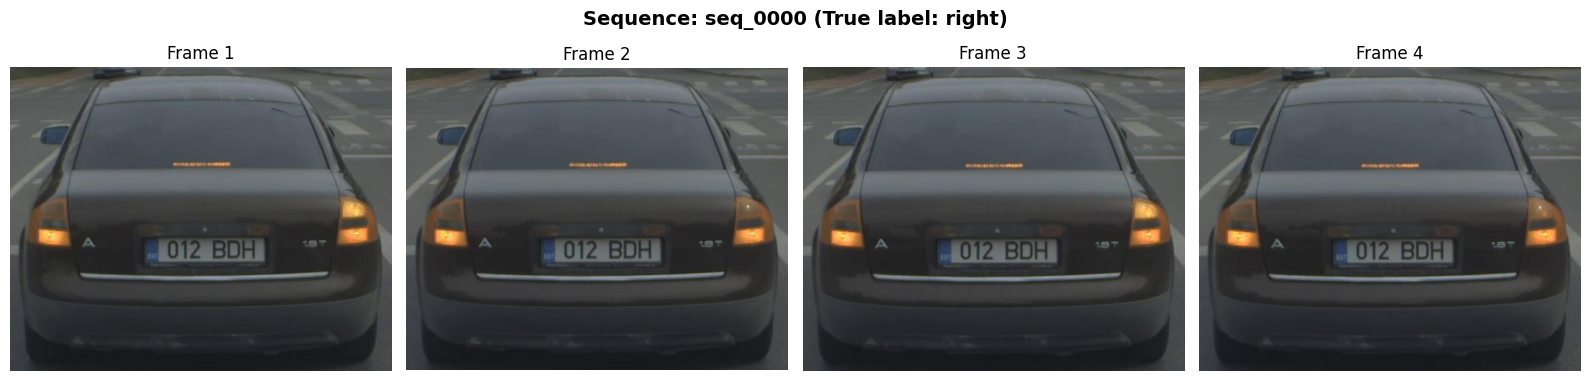

In [10]:
fig, axes = plt.subplots(1, len(test_paths), figsize=(16, 4))
for i, path in enumerate(test_paths):
    img = Image.open(path)
    axes[i].imshow(img)
    axes[i].set_title(f'Frame {i+1}')
    axes[i].axis('off')
plt.suptitle(f'Sequence: {seq_id} (True label: {true_label})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
comp_result = analyze_sequence_computational(test_paths)

print(json.dumps(comp_result, indent=2))

{
  "predicted_signal": "right",
  "left_activity": 21094.507986381195,
  "right_activity": 67049.48489735025
}


# Test Single Sequence - API Method

In [12]:
api_result = label_with_api_grid(test_paths, use_computational_hint=False)

In [13]:
print(json.dumps(api_result, indent=2))

{
  "label": "right",
  "reasoning": "The right turn signal is blinking in the second and fourth images, while the left signal remains off.",
  "confidence": 0.9,
  "method": "api_grid",
  "used_computational_hint": false
}


In [14]:
api_hint_result = label_with_api_grid(test_paths, use_computational_hint=True)

In [15]:
print(json.dumps(api_hint_result, indent=2))

{
  "label": "hazard",
  "reasoning": "Both left and right turn signals are blinking simultaneously across the frames.",
  "confidence": 0.9,
  "method": "api_grid",
  "used_computational_hint": true,
  "computational_prediction": "right",
  "agrees_with_computational": false
}


# Full Dataset - Computational Method

In [12]:
results_comp = process_all_sequences(
    label_csv=LABEL_CSV,
    image_base_path=IMAGE_BASE,
    method='computational',
    output_path=f'{OUTPUT_DIR}/results_computational.json'
)

Processing 21 sequences
Method: computational
Model: N/A
------------------------------------------------------------

[1/21] seq_0000
  True: right, Frames: 13
  Predicted: right ✓

[2/21] seq_0001
  True: left, Frames: 13
  Predicted: left ✓

[3/21] seq_0002
  True: left, Frames: 13
  Predicted: left ✓

[4/21] seq_0003
  True: right, Frames: 11
  Predicted: right ✓

[5/21] seq_0004
  True: right, Frames: 13
  Predicted: right ✓

[6/21] seq_0005
  True: left, Frames: 13
  Predicted: left ✓

[7/21] seq_0006
  True: left, Frames: 13
  Predicted: left ✓

[8/21] seq_0007
  True: right, Frames: 13
  Predicted: right ✓

[9/21] seq_0008
  True: right, Frames: 13
  Predicted: right ✓

[10/21] seq_0009
  True: left, Frames: 13
  Predicted: left ✓

[11/21] seq_0010
  True: hazard, Frames: 13
  Predicted: hazard ✓

[12/21] seq_0011
  True: none, Frames: 13
  Predicted: none ✓

[13/21] seq_0012
  True: none, Frames: 13
  Predicted: none ✓

[14/21] seq_0013
  True: none, Frames: 12
  Predicted: no

In [13]:
metrics_comp = evaluate_results(results_comp)


Accuracy: 85.7% (18/21)

Confusion Matrix:
Predicted  hazard  left  none  right
True                                
hazard          1     0     0      0
left            0     5     0      0
none            2     1     7      0
right           0     0     0      5


In [30]:
with open(f'{OUTPUT_DIR}/metrics_computational.json', 'w') as f:
    json.dump(metrics_comp, f, indent=2)

# Run API (on Limited Set)

In [14]:
results_api = process_all_sequences(
    label_csv=LABEL_CSV,
    image_base_path=IMAGE_BASE,
    method='api',
    model='gpt-4o-mini',
    output_path=f'{OUTPUT_DIR}/results_api_sample.json',
    max_sequences=10,  # Only 10 sequences
    delay=1.0
)

Processing 10 sequences
Method: api
Model: gpt-4o-mini
------------------------------------------------------------

[1/10] seq_0000
  True: right, Frames: 13
  Predicted: none ✗

[2/10] seq_0001
  True: left, Frames: 13
  Predicted: left ✓

[3/10] seq_0002
  True: left, Frames: 13
  Predicted: right ✗

[4/10] seq_0003
  True: right, Frames: 11
  Predicted: right ✓

[5/10] seq_0004
  True: right, Frames: 13
  Predicted: left ✗

[6/10] seq_0005
  True: left, Frames: 13
  Predicted: left ✓

[7/10] seq_0006
  True: left, Frames: 13
  Predicted: right ✗

[8/10] seq_0007
  True: right, Frames: 13
  Predicted: right ✓

[9/10] seq_0008
  True: right, Frames: 13
  Predicted: left ✗

[10/10] seq_0009
  True: left, Frames: 13
  Predicted: right ✗

Results saved to: results/results_api_sample.json


In [15]:
metrics_api = evaluate_results(results_api)


Accuracy: 40.0% (4/10)

Confusion Matrix:
Predicted  left  none  right
True                        
left          2     0      3
right         2     1      2


In [29]:
with open(f'{OUTPUT_DIR}/metrics_api_sample.json', 'w') as f:
    json.dump(metrics_api, f, indent=2)

In [16]:
results_api_hint = process_all_sequences(
    label_csv=LABEL_CSV,
    image_base_path=IMAGE_BASE,
    method='api_with_hint',  # Using computational hint
    model='gpt-4o-mini',
    output_path=f'{OUTPUT_DIR}/results_api_hint_sample.json',
    max_sequences=10,
    delay=1.0
)

Processing 10 sequences
Method: api_with_hint
Model: gpt-4o-mini
------------------------------------------------------------

[1/10] seq_0000
  True: right, Frames: 13
  Predicted: none ✗

[2/10] seq_0001
  True: left, Frames: 13
  Predicted: left ✓

[3/10] seq_0002
  True: left, Frames: 13
  Predicted: left ✓

[4/10] seq_0003
  True: right, Frames: 11
  Predicted: right ✓

[5/10] seq_0004
  True: right, Frames: 13
  Predicted: none ✗

[6/10] seq_0005
  True: left, Frames: 13
  Predicted: left ✓

[7/10] seq_0006
  True: left, Frames: 13
  Predicted: left ✓

[8/10] seq_0007
  True: right, Frames: 13
  Predicted: none ✗

[9/10] seq_0008
  True: right, Frames: 13
  Predicted: right ✓

[10/10] seq_0009
  True: left, Frames: 13
  Predicted: left ✓

Results saved to: results/results_api_hint_sample.json


In [17]:
metrics_api_hint = evaluate_results(results_api_hint)


Accuracy: 70.0% (7/10)

Confusion Matrix:
Predicted  left  none  right
True                        
left          5     0      0
right         0     3      2


In [23]:
with open(f'{OUTPUT_DIR}/metrics_api_hint_sample.json', 'w') as f:
    json.dump(metrics_api_hint, f, indent=2)

In [24]:
if 'agrees_with_computational' in results_api_hint['result'].iloc[0]:
    agreement_rate = results_api_hint['result'].apply(
        lambda x: x.get('agrees_with_computational', False)
    ).mean()
    print(f"\nAPI agrees with computational: {agreement_rate:.1%}")


API agrees with computational: 70.0%


In [25]:
def load_metrics(path):
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except:
        return None

In [33]:
comp_metrics = load_metrics(f'{OUTPUT_DIR}/metrics_computational.json')
api_metrics = load_metrics(f'{OUTPUT_DIR}/metrics_api_sample.json')
hint_metrics = load_metrics(f'{OUTPUT_DIR}/metrics_api_hint_sample.json')

In [35]:
comparison_data = []

if comp_metrics:
    comparison_data.append({
        'Method': 'Computational',
        'Accuracy': f"{comp_metrics['accuracy']:.1%}",
        'Correct': comp_metrics['correct'],
        'Total': comp_metrics['total'],
    })

if api_metrics:
    comparison_data.append({
        'Method': 'API Only',
        'Accuracy': f"{api_metrics['accuracy']:.1%}",
        'Correct': api_metrics['correct'],
        'Total': api_metrics['total'],
    })

if hint_metrics:
    comparison_data.append({
        'Method': 'API + Hint',
        'Accuracy': f"{hint_metrics['accuracy']:.1%}",
        'Correct': hint_metrics['correct'],
        'Total': hint_metrics['total'],
    })

comparison_df = pd.DataFrame(comparison_data)

In [36]:
comparison_df

,Method,Accuracy,Correct,Total
0,Computational,85.7%,18,21
1,API Only,40.0%,4,10
2,API + Hint,70.0%,7,10
